## Keras model 
---- 
* **Why Keras ? **


 > 실질적으로 풀려는 문제가 풀리는 문제 일까 아닐까를 정의가 안된 시점에서, 얕은 모델 부터 깊고 복잡한 모델까지 모두 실험해 보기 위해서 모델을 만들고 러닝 하여, 결과를 확인하는 과정에 사이클을 짧게 하기위함이 첫번째 이유이고, 두번째는 데이터를 직접 resizing하지 않아서 tfrecord로 파싱하는데 오류가 있었기 때문이다. 
 
* **현재 모델**
> **VGG alike** : 맨 처음 1x1conv layer로 gray scals 을 만들고 다음 VGG와 비슷한 구조로 conv을 수행한 후 FCN으로 넘어간다. 


> 얕은 모델 버전 


In [1]:
import numpy as np 
import pickle 

# load dataset 
with open('../sample_image/sample560_crop_df.bin', 'rb') as f :
    crop_img = pickle.load(f)

X = np.array([i for i in crop_img.crop_images])
y = crop_img.weight.values

In [2]:
#Parameters 

BATCH_SIZE = 24

In [3]:
### test/train split 
idx = list(np.random.randint(0, len(X), int(len(X) * 0.8)))
test_idx = list(set(list(range(len(X)))) - set(idx))

X_train = X[idx]
y_train = y[idx]
X_test = X[test_idx]
y_test = y[test_idx]

In [4]:
# image augmentation 
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

gen.fit(X_train, augment=True)

Using TensorFlow backend.


In [5]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.layers import Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2


def cnn_model():
    model = Sequential()
    #  first layer for making images to the gray scale images, more precisely 
    model.add(Conv2D(1, (1, 1), activation='relu', input_shape=(250, 550, 3), padding='same', kernel_regularizer=l2(0.001)))

    # 
    model.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    model.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(32, (7, 7), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(32, (7, 7), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (7, 7), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(64, (7, 7), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(127, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    return model 



In [6]:
from keras.utils.training_utils import multi_gpu_model

model = cnn_model()
model = multi_gpu_model(model, gpus=2)
model.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['mae'])

In [8]:
%%time
hist = model.fit_generator(gen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                           steps_per_epoch=len(X_train)/BATCH_SIZE,
                          epochs=200, validation_data=(X_test, y_test), verbose=2)

Epoch 1/200
 - 40s - loss: 8941.0193 - mean_absolute_error: 82.1666 - val_loss: 12270.9193 - val_mean_absolute_error: 110.1104
Epoch 2/200
 - 23s - loss: 4023.2084 - mean_absolute_error: 51.6550 - val_loss: 12270.9906 - val_mean_absolute_error: 110.1104
Epoch 3/200
 - 22s - loss: 1714.5258 - mean_absolute_error: 33.1504 - val_loss: 71437611.5840 - val_mean_absolute_error: 7488.8938
Epoch 4/200
 - 23s - loss: 1142.9458 - mean_absolute_error: 26.7841 - val_loss: 71388752.4480 - val_mean_absolute_error: 8112.0221
Epoch 5/200
 - 22s - loss: 962.9366 - mean_absolute_error: 24.3333 - val_loss: 641864375.8080 - val_mean_absolute_error: 24596.2357
Epoch 6/200
 - 22s - loss: 1084.9548 - mean_absolute_error: 26.0985 - val_loss: 397048866.3040 - val_mean_absolute_error: 19554.2085
Epoch 7/200
 - 23s - loss: 1003.6754 - mean_absolute_error: 25.5381 - val_loss: 188022916.3520 - val_mean_absolute_error: 13400.7174
Epoch 8/200
 - 23s - loss: 979.6696 - mean_absolute_error: 25.5149 - val_loss: 3110785

Epoch 64/200
 - 22s - loss: 401.1799 - mean_absolute_error: 15.5840 - val_loss: 28561561.7920 - val_mean_absolute_error: 5183.4175
Epoch 65/200
 - 22s - loss: 370.4138 - mean_absolute_error: 15.2637 - val_loss: 13929178.1880 - val_mean_absolute_error: 3485.4454
Epoch 66/200
 - 22s - loss: 425.2668 - mean_absolute_error: 16.5024 - val_loss: 27625293.4400 - val_mean_absolute_error: 4975.2715
Epoch 67/200
 - 22s - loss: 381.3833 - mean_absolute_error: 15.2508 - val_loss: 13479570.9840 - val_mean_absolute_error: 3436.1700
Epoch 68/200
 - 23s - loss: 359.4776 - mean_absolute_error: 15.2204 - val_loss: 5809223.7360 - val_mean_absolute_error: 2280.7829
Epoch 69/200
 - 23s - loss: 319.5671 - mean_absolute_error: 14.1058 - val_loss: 9266720.9240 - val_mean_absolute_error: 2860.2118
Epoch 70/200
 - 22s - loss: 324.3892 - mean_absolute_error: 14.6606 - val_loss: 3511364.4720 - val_mean_absolute_error: 1718.9796
Epoch 71/200
 - 22s - loss: 434.2236 - mean_absolute_error: 16.6698 - val_loss: 831355

Epoch 127/200
 - 23s - loss: 386.0886 - mean_absolute_error: 15.4245 - val_loss: 5257612.6190 - val_mean_absolute_error: 2035.0209
Epoch 128/200
 - 22s - loss: 317.6230 - mean_absolute_error: 14.2708 - val_loss: 6366152.0120 - val_mean_absolute_error: 2335.7781
Epoch 129/200
 - 24s - loss: 347.0789 - mean_absolute_error: 15.1630 - val_loss: 9889093.4800 - val_mean_absolute_error: 2871.8187
Epoch 130/200
 - 22s - loss: 325.4200 - mean_absolute_error: 14.2208 - val_loss: 6728865.3460 - val_mean_absolute_error: 2348.1439
Epoch 131/200
 - 23s - loss: 314.0324 - mean_absolute_error: 13.8625 - val_loss: 7431704.6440 - val_mean_absolute_error: 2405.6739
Epoch 132/200
 - 22s - loss: 377.6606 - mean_absolute_error: 15.5185 - val_loss: 3484333.0330 - val_mean_absolute_error: 1665.8634
Epoch 133/200
 - 23s - loss: 347.1641 - mean_absolute_error: 15.0921 - val_loss: 3263868.3760 - val_mean_absolute_error: 1646.6019
Epoch 134/200
 - 23s - loss: 306.9116 - mean_absolute_error: 13.8145 - val_loss: 27

Epoch 190/200
 - 23s - loss: 328.3893 - mean_absolute_error: 14.4416 - val_loss: 718930.5800 - val_mean_absolute_error: 773.1111
Epoch 191/200
 - 23s - loss: 324.2923 - mean_absolute_error: 14.3151 - val_loss: 1155700.8123 - val_mean_absolute_error: 905.1672
Epoch 192/200
 - 23s - loss: 317.0173 - mean_absolute_error: 14.3519 - val_loss: 1255755.2784 - val_mean_absolute_error: 969.9350
Epoch 193/200
 - 22s - loss: 294.4578 - mean_absolute_error: 13.6716 - val_loss: 795206.3366 - val_mean_absolute_error: 743.2737
Epoch 194/200
 - 22s - loss: 252.5556 - mean_absolute_error: 12.3362 - val_loss: 1324208.9667 - val_mean_absolute_error: 1007.5744
Epoch 195/200
 - 22s - loss: 273.7727 - mean_absolute_error: 13.4640 - val_loss: 935617.4725 - val_mean_absolute_error: 810.4038
Epoch 196/200
 - 23s - loss: 335.8842 - mean_absolute_error: 14.5633 - val_loss: 1300439.2485 - val_mean_absolute_error: 982.0202
Epoch 197/200
 - 22s - loss: 347.2324 - mean_absolute_error: 15.0336 - val_loss: 797449.0921

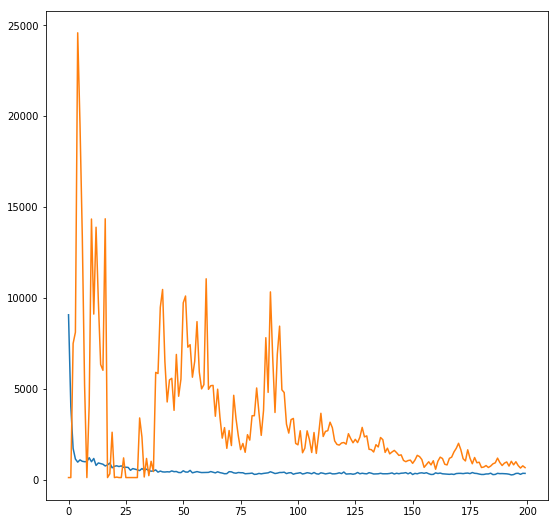

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9,9))
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_mean_absolute_error"])
plt.show()

In [15]:
r = 0
print("prediction : {}, Truth : {} ".format(model.predict(np.array(X_test[r])), y_test[r]))

1       95.30
2       97.36
514    122.39
5       98.56
6       99.80
7       97.10
8       97.42
522    126.24
11      92.20
524    126.43
525    125.53
526    128.26
528    128.98
529    120.29
530    121.74
21      98.65
533    120.63
23      95.37
24      97.85
534    120.94
535    124.17
27      96.42
540    125.27
29      92.69
30      93.89
31      92.22
541    127.06
542    127.88
546    126.42
35      91.98
        ...  
444    129.06
445    128.88
447    126.02
448    128.24
450    120.70
456    120.52
458    122.39
459    122.28
461    127.75
462    128.23
466    126.16
468    128.88
470    123.79
472    124.62
477    122.34
480    128.90
481    127.67
486    128.12
489    121.16
491    121.91
492    123.46
497    120.14
500    126.33
501    128.92
503    125.12
504    127.25
507    126.02
508    125.60
509    123.08
510    120.92
Name: weight, Length: 251, dtype: float64